# Analyze Ball on Incline data

In [1]:
# Imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy import stats
import pandas as pd
import sympy as sp
import seaborn as sns

sns.set()
sns.set_palette("husl",8)

from iminuit import Minuit
sys.path.append('../../External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

# Define functions


In [2]:
def read_csv(filename):
    dat = np.genfromtxt(filename, delimiter=',', skip_header=13, names=True)
    time = dat['Time_s']
    voltage = dat['Channel_1_V']
    return time, voltage

In [3]:
def RMSD(data):
    return np.sqrt(np.sum((data-data.mean())**2)/(len(data)-1))

In [4]:
def weighted_average(data, errors):
    avg = np.sum(data/errors**2)/np.sum(1/errors**2)
    err = np.sqrt(1/np.sum(1/errors**2))
    exp = avg*np.ones(len(data))
    chi2 = np.sum(((data-exp)/errors)**2)
    dof = len(data)
    p = 1 - stats.chi2.cdf(chi2, dof)
    return avg, err, chi2, p

In [5]:
def plot_raw_data(x, y):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(x, y, 'k.', label='Measurements')
    ax.set_title("Data from Ball-on-Incline experiment")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (V)")

In [6]:
def fit_parabola(x, y, sy, plot=bool):
    
    def func_para(x, a, v0, s0):
        return (1/2)*a*x*x+v0*x+s0

    #initial parameters to feed to minuit
    a, v0, s0 = curve_fit(func_para, peak_times, gate_pos)[0] 
    
    #fit by Minuit
    chi2_object = Chi2Regression(func_para, x, y, sy)
    chi2_object.errordef = Minuit.LEAST_SQUARES
    minuit = Minuit(chi2_object, a=a, v0=v0, s0=s0)
    minuit.migrad();
    a, v0, s0 = minuit.values[:]
    
    #get chi2 value
    chi2_val = minuit.fval
    
    #get number of degrees of freedom
    N_DOF = len(x) - len(minuit.values[:])
    
    #get chi2 probability
    chi2_prob = stats.chi2.sf(chi2_val, N_DOF)
    
    if plot:
        #plot fit 
        x_fit = np.linspace(0, 1, 1000)
        y_fit = func_para(x_fit, a, v0, s0)

        d = {'Entries':  len(x),
         'Chi2':     chi2_val,
         'ndf':      N_DOF,
         'Prob':     chi2_prob}

        #add fit parameters to text box
        for name in minuit.parameters:
            d[name] = [minuit.values[name], minuit.errors[name]]

        text = nice_string_output(d, extra_spacing=2, decimals=3)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.errorbar(x, y, yerr=sy, fmt='ko', label='Data')
        ax.plot(x_fit, y_fit, '-', label='Fit by Minuit')
        ax.set_title('Fit of parabola by Minuit', fontsize = 15)
        ax.set_xlim(0,0.9)
        ax.set_xlabel('Time (s)', fontsize = 15)
        ax.set_ylabel('Position (m)', fontsize = 15)
        add_text_to_ax(0.02, 0.95, text, ax, fontsize=15)
        ax.legend(prop={"size":15})
        fig.tight_layout()
    
    return minuit.values['a'], minuit.errors['a'], chi2_val, chi2_prob
#     return minuit.values['a'], minuit.errors['a'], chi2_val, chi2_prob, fig

## Reading and plotting the data (example)

The function "read_csv(filename)" takes in a filename and returns numpy arrays with time and voltage.

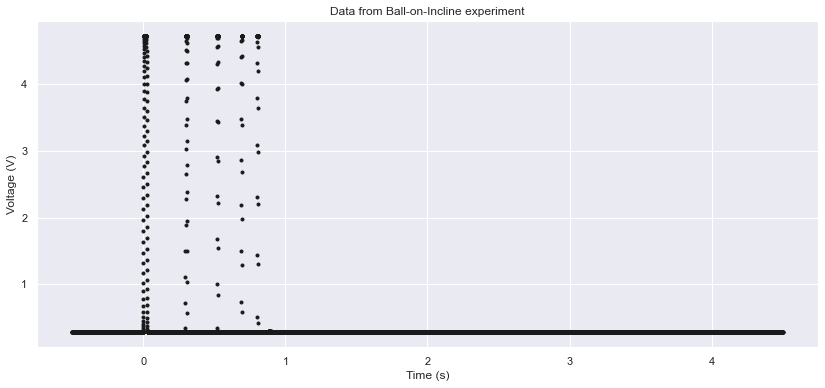

In [7]:
# Read and plot the raw data 
filename = 'amalie_norm.csv'
time, voltage = read_csv(filename)

plot_raw_data(time, voltage)

In [8]:
#input gate positions
gate_pos = np.array([13.05, 29.90, 52.20, 74.45, 92.45])/100
gate_pos_err = (0.05*np.ones(len(gate_pos))/100)*5

#locate peak times
peak_index, peak_height = find_peaks(voltage, height = 2)
peak_times = time[peak_index]

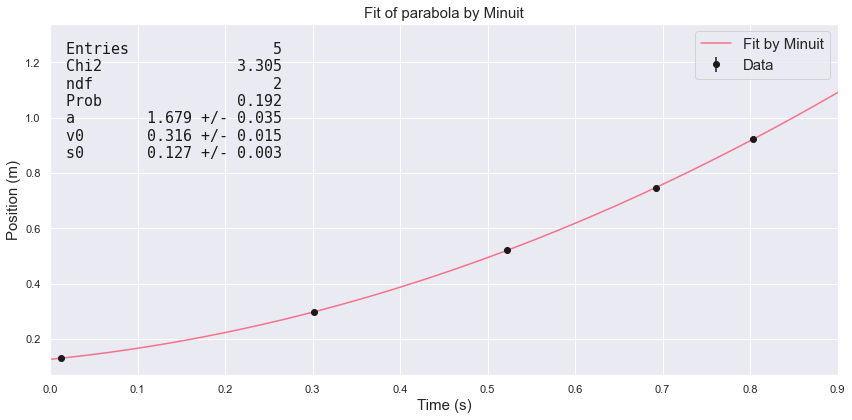

In [9]:
#fit parabola to peak times and positions
acc, acc_err, chi2, p = fit_parabola(peak_times, gate_pos, gate_pos_err)

# acc, acc_err, chi2, p, fig = fit_parabola(peak_times, gate_pos, gate_pos_err)
# fig.savefig('parabola_fit_example.png')

In [10]:
print(f"  Fit value for acceleration (example): {acc:.5f} +/- {acc_err:.5f} m/s^2, Chi2: {chi2:.5f}, p: {p:.5f}")

  Fit value for acceleration (example): 1.67928 +/- 0.03469 m/s^2, Chi2: 3.30498, p: 0.19157


# Get acceleration from all 5 measurements

In [11]:
#make empty lists for accelerations and errors for normal setup and reversed setup
acc_norm = []
acc_norm_err = []
acc_rev = []
acc_rev_err = []
chi2_norm = []
chi2_rev = []
p_norm = []
p_rev = []

#read gate positions and estimates on error
gate_poss = np.genfromtxt('gate_positions.dat', delimiter=',', names=('index', 'amalie', 'soren', 'sara', 'lukas', 'elloise'))

names = ['amalie', 'soren', 'sara', 'lukas', 'elloise']

#get acceleration values for normal setup
for name in names:
    #read correct file
    filename = name+'_norm.csv'
    time, voltage = read_csv(filename)
    
    #extract gate positions and error estimate
    gate_pos = gate_poss[name][:-1]
    if name != 'lukas':
        gate_pos_err = gate_poss[name][-1]*5
    else:
        gate_pos_err = gate_poss[name][-1]
    
    #find peaks in voltage
    peak_index, peak_height = find_peaks(voltage, height=2)
    peak_times = time[peak_index]
    
    #fit parabola to (time, position) curve and extract acceleration
    acc, acc_err, chi2, p = fit_parabola(peak_times, gate_pos, gate_pos_err, plot=False)
    
    #add acceleration and error to respective lists
    acc_norm.append(acc)
    acc_norm_err.append(acc_err)
    chi2_norm.append(chi2)
    p_norm.append(p)

#get acceleration values for reversed setup
for name in names:
    #read correct file
    filename = name+'_rev.csv'
    time, voltage = read_csv(filename)
    
    #extract gate positions and error estimate
    gate_pos = gate_poss[name][:-1]
    if name != 'lukas':
        gate_pos_err = gate_poss[name][-1]*5
    else:
        gate_pos_err = gate_poss[name][-1]
    
    #find peaks in voltage
    peak_index, peak_height = find_peaks(voltage, height=2)
    peak_times = time[peak_index]
    
    #fit parabola to (time, position) curve and extract acceleration
    acc, acc_err, chi2, p = fit_parabola(peak_times, gate_pos, gate_pos_err, plot=False)
    
    #add acceleration and error to respective lists
    acc_rev.append(acc)
    acc_rev_err.append(acc_err)
    chi2_rev.append(chi2)
    p_rev.append(p)
    

In [12]:
#show in dataframe
df = pd.DataFrame({'Acceleration (normal)': acc_norm,
                   'Error (normal)': acc_norm_err,
                   'Chi2 (normal)': chi2_norm,
                   'P-value (normal)': p_norm,
                   'Acceleration (reversed)': acc_rev,
                   'Error (reversed)': acc_rev_err,
                   'Chi2 (reversed)': chi2_rev,
                   'P-value (reversed)': p_rev},
                  index=['Amalie', 'Søren', 'Sara', 'Lukas', 'Elloise'])

df

,Acceleration (normal),Error (normal),Chi2 (normal),P-value (normal),Acceleration (reversed),Error (reversed),Chi2 (reversed),P-value (reversed)
Amalie,1.679282,0.034692,3.304980,0.191572,1.750760,0.035879,3.662528,0.160211
Søren,1.677841,0.020561,7.141998,0.028128,1.754159,0.021688,5.639648,0.059616
Sara,1.680050,0.034852,2.617338,0.270179,1.748047,0.036122,2.726827,0.255786
Lukas,1.668477,0.027600,6.133437,0.046574,1.740201,0.028694,5.418152,0.066598
Elloise,1.680181,0.034838,3.395884,0.183060,1.747100,0.036236,3.152628,0.206736


In [13]:
#weighted averages and errors of accleration (normal and reversed setup)
acc_avg_norm, acc_avg_norm_err, acc_avg_norm_chi2, acc_avg_norm_p = weighted_average(acc_norm, np.array(acc_norm_err))
acc_avg_rev, acc_avg_rev_err, acc_avg_rev_chi2, acc_avg_rev_p = weighted_average(acc_rev, np.array(acc_rev_err))
print(f"  Weighted average of acceleration (normal): {acc_avg_norm:.5f} +/- {acc_avg_norm_err:.5f} m/s^2, Chi2: {acc_avg_norm_chi2:.5f}, p: {acc_avg_norm_p:.5f}")
print(f"  Weighted average of acceleration (reversed): {acc_avg_rev:.5f} +/- {acc_avg_rev_err:.5f} m/s^2, Chi2: {acc_avg_rev_chi2:.5f}, p: {acc_avg_rev_p:.5f}")

  Weighted average of acceleration (normal): 1.67665 +/- 0.01275 m/s^2, Chi2: 0.11659, p: 0.99976
  Weighted average of acceleration (reversed): 1.74891 +/- 0.01331 m/s^2, Chi2: 0.15642, p: 0.99951


# Compute trigonometric angle

In [14]:
#load triangle measurements
tri = np.genfromtxt('triangle_sides.dat', delimiter=',', names=('long', 'err_long', 'short', 'err_short'))

#compute weighted averages of measurements
long_avg, long_avg_err, long_avg_chi2, long_avg_p = weighted_average(tri['long'], tri['err_long'])
short_avg, short_avg_err, short_avg_chi2, short_avg_p = weighted_average(tri['short'], tri['err_short'])
print(f"  Weighted average of long side length: {long_avg:.5f} +/- {long_avg_err:.5f} m, Chi2: {long_avg_chi2:.5f}, p: {long_avg_p}")
print(f"  Weighted average of short side length: {short_avg:.5f} +/- {short_avg_err:.5f} m, Chi2: {short_avg_chi2:.5f}, p: {short_avg_p}")

  Weighted average of long side length: 0.98986 +/- 0.00014 m, Chi2: 588.57293, p: 0.0
  Weighted average of short side length: 0.27286 +/- 0.00009 m, Chi2: 498.40895, p: 0.0


In [15]:
# #use arithmetic mean and RMSD instead
# long_avg, long_avg_err, long_avg_chi2, long_avg_p = weighted_average(tri['long'], RMSD(tri['long'])*np.ones(len(tri['long'])))
# short_avg, short_avg_err, short_avg_chi2, short_avg_p = weighted_average(tri['short'], RMSD(tri['short'])*np.ones(len(tri['short'])))
# print(f"  Weighted average of long side length: {long_avg:.5f} +/- {long_avg_err:.5f} m, Chi2: {long_avg_chi2:.5f}, p: {long_avg_p:.5f}")
# print(f"  Weighted average of short side length: {short_avg:.5f} +/- {short_avg_err:.5f} m, Chi2: {short_avg_chi2:.5f}, p: {short_avg_p:.5f}")

In [16]:
#compute trigonometric angle and error using sympy

# Define variables:
x,y,dx,dy = sp.symbols("x, y, dx, dy")

# Define relation:
f = sp.atan(x/y)

# Calculate uncertainty:
df = sp.sqrt((f.diff(x) * dx)**2 + (f.diff(y) * dy)**2)

# Turn expression into numerical functions 
f_func = sp.lambdify((x,y),f)
df_func = sp.lambdify((x,dx,y,dy),df)

# Define values and their errors
vx, vdx = short_avg, short_avg_err
vy, vdy = long_avg, long_avg_err

# Numerically evaluate expressions and print 
trig_ang = f_func(vx,vy)*(180/np.pi)
trig_ang_err = df_func(vx,vdx,vy,vdy)*(180/np.pi)

print(f"  Trigonometric angle: {trig_ang:.5f} +/- {trig_ang_err:.5f} degrees")

  Trigonometric angle: 15.41093 +/- 0.00530 degrees


# Compute delta angle (difference in acceleration)

In [17]:
#angle of table to ground from difference in acceleration (using sympy)

# Define variables:
x,y,z,dx,dy,dz = sp.symbols("x, y, z, dx, dy, dz")

# Define relation:
f = (x-y)*sp.sin(z*sp.pi/180)/((x+y)*sp.cos(z*sp.pi/180))

# Calculate uncertainty:
df = sp.sqrt((f.diff(x)*dx)**2 + (f.diff(y)*dy)**2 + (f.diff(z)*dz)**2)

# Turn expression into numerical functions 
f_func = sp.lambdify((x,y,z),f)
df_func = sp.lambdify((x,dx,y,dy,z,dz),df)

# Define values and their errors
vx, vdx = acc_avg_norm, acc_avg_norm_err
vy, vdy = acc_avg_rev, acc_avg_rev_err
vz, vdz = trig_ang, trig_ang_err

# Numerically evaluate expressions and print 
delta_ang_acc = abs(f_func(vx,vy,vz)*(180/np.pi))
delta_ang_acc_err = df_func(vx,vdx,vy,vdy,vz,vdz)*(180/np.pi)

print(f"  Delta angle from difference in acceleration: {delta_ang_acc:.5f} +/- {delta_ang_acc_err:.5f} degrees")

  Delta angle from difference in acceleration: 0.33315 +/- 0.08490 degrees


# Compute delta angle (by flipping setup)

In [18]:
#load and average goniometer measurements
gonio = np.genfromtxt('gonio_wo_elloi.dat', delimiter=',', names=('norm', 'err_norm', 'rev', 'err_rev')) #elloise's data removed
norm, err_norm, rev, err_rev = gonio['norm'], gonio['err_norm'], gonio['rev'], gonio['err_rev']

#weighted averages and errors of accleration (normal and reversed setup)
gonio_avg_norm, gonio_avg_norm_err, gonio_avg_norm_chi2, gonio_avg_norm_p = weighted_average(norm, err_norm)
gonio_avg_rev, gonio_avg_rev_err, gonio_avg_rev_chi2, gonio_avg_rev_p = weighted_average(rev, err_rev)
print(f"  Weighted average of gonio angles (normal): {gonio_avg_norm:.5f} +/- {gonio_avg_norm_err:.5f} degrees, Chi2: {gonio_avg_norm_chi2:.5f}, p: {gonio_avg_norm_p:.5f}")
print(f"  Weighted average of gonio angles (reversed): {gonio_avg_rev:.5f} +/- {gonio_avg_rev_err:.5f} degrees, Chi2: {gonio_avg_rev_chi2:.5f}, p: {gonio_avg_rev_p:.5f}")

  Weighted average of gonio angles (normal): 14.76538 +/- 0.03922 degrees, Chi2: 56.47115, p: 0.00000
  Weighted average of gonio angles (reversed): 15.07826 +/- 0.04170 degrees, Chi2: 606.97826, p: 0.00000


In [19]:
#add systematic error to gonio measurements
diffs_norm = []
diffs_rev = []

for i in range(len(norm)):
    for n in range(len(norm)):
        diffs_norm.append(err_norm[i]-err_norm[n])
        diffs_rev.append(err_rev[i]-err_rev[n])

diff_norm = np.abs(np.array(diffs_norm))
diff_rev = np.abs(np.array(diffs_rev))

gonio_avg_norm, gonio_avg_norm_err, gonio_avg_norm_chi2, gonio_avg_norm_p = weighted_average(norm, err_norm+diff_norm.max())
gonio_avg_rev, gonio_avg_rev_err, gonio_avg_rev_chi2, gonio_avg_rev_p = weighted_average(rev, err_rev+diff_rev.max())
print(f"  Weighted average of gonio angles (normal): {gonio_avg_norm:.5f} +/- {gonio_avg_norm_err:.5f} degrees, Chi2: {gonio_avg_norm_chi2:.5f}, p: {gonio_avg_norm_p:.5f}")
print(f"  Weighted average of gonio angles (reversed): {gonio_avg_rev:.5f} +/- {gonio_avg_rev_err:.5f} degrees, Chi2: {gonio_avg_rev_chi2:.5f}, p: {gonio_avg_rev_p:.5f}")

  Weighted average of gonio angles (normal): 14.76452 +/- 0.07620 degrees, Chi2: 14.72760, p: 0.06466
  Weighted average of gonio angles (reversed): 14.96667 +/- 0.07947 degrees, Chi2: 258.90741, p: 0.00000


In [20]:
#angle of table to ground by flipping setup 
delta_ang_flip = abs((gonio_avg_rev-gonio_avg_norm)/2)
delta_ang_flip_err = np.sqrt((gonio_avg_norm_err/2)**2+(gonio_avg_rev_err/2)**2)
print(f"  Delta angle from flipping setup: {delta_ang_flip:.5f} +/- {delta_ang_flip_err:.5f} degrees")

  Delta angle from flipping setup: 0.10108 +/- 0.05505 degrees


### Justify not using Elloise's gonio measurements

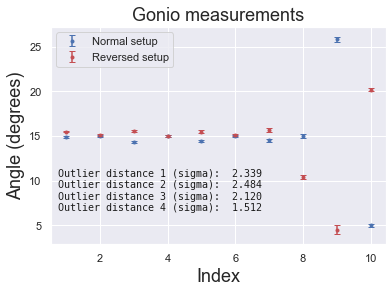

In [21]:
#scatter plot of our gonio measurements
gonio_full = np.genfromtxt('gonio.dat', delimiter=',', names=('norm', 'err_norm', 'rev', 'err_rev'))
norm_full, err_norm_full, rev_full, err_rev_full = gonio_full['norm'], gonio_full['err_norm'], gonio_full['rev'], gonio_full['err_rev']

distances = []
for i in [-2,-1]:
    distances.append(np.round(abs(norm_full[i]-norm_full.mean())/norm_full.std(),3))
    distances.append(np.round(abs(rev_full[i]-rev_full.mean())/rev_full.std(),3))

x = np.linspace(1, len(norm_full), len(norm_full))

d = {'Outlier distance 1 (sigma):': distances[0],
     'Outlier distance 2 (sigma):': distances[1],
     'Outlier distance 3 (sigma):': distances[2],
     'Outlier distance 4 (sigma):': distances[3]}

fig, ax = plt.subplots(1)
ax.errorbar(x, norm_full, yerr=err_norm_full, fmt='b.', label='Normal setup', capsize=3)
ax.errorbar(x, rev_full, yerr=err_rev_full, fmt='r.', label='Reversed setup', capsize=3)
ax.set_title('Gonio measurements', fontsize=18)
ax.set_xlabel('Index', fontsize=18)
ax.set_ylabel('Angle (degrees)', fontsize=18)
text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.02, 0.35, text, ax, fontsize=10)
ax.legend();

# fig.savefig('Gonio outliers.png')

# Combine delta angle results

In [22]:
#weighted average of delta angle from diff in acc and from flipping setup
final_delta_ang, final_delta_ang_err, final_delta_ang_chi2, final_delta_ang_p = weighted_average(np.array([delta_ang_flip,delta_ang_acc]), np.array([delta_ang_flip_err, delta_ang_acc_err]))
print(f"Weighted average of delta angle: {final_delta_ang:.5f} +/- {final_delta_ang_err:.5f} m/s^2, chi2: {final_delta_ang_chi2:.5f}, p: {final_delta_ang_p:.5f}")

Weighted average of delta angle: 0.16977 +/- 0.04619 m/s^2, chi2: 5.26025, p: 0.07207


# Combine measurements of rail width

In [23]:
#load and average rail width measurements
rail = np.genfromtxt('rail_width.dat', delimiter=',', names=('width', 'err'))
rail_width, rail_width_err = rail['width'], rail['err']

rail_width_avg, rail_width_avg_err, rail_width_avg_chi2, rail_width_avg_p = weighted_average(rail_width, rail_width_err)
print(f"  Weighted average of rail width measurements: {rail_width_avg:.5f} +/- {rail_width_avg_err:.5f} m, Chi2: {rail_width_avg_chi2:.5f}, p: {rail_width_avg_p:.5f}")

  Weighted average of rail width measurements: 0.00603 +/- 0.00006 m, Chi2: 0.69605, p: 0.98318


# Diameter of ball (measured by Troels)

In [24]:
ball = 0.01271
ball_err = 0.0001 #my estimate of the precision
print(f" Diameter of ball (measured by Troels): {ball:.5f} +/- {ball_err:.5f} m")

 Diameter of ball (measured by Troels): 0.01271 +/- 0.00010 m


# Combine everything

In [25]:
# #take derivaties of g
# a,t,dt,D,d = sp.symbols("a, t, dt, D, d")
# g_norm = (a/sp.sin(t-dt))*(1+((2/5)*D**2/(D**2-d**2)))
# g_rev = (a/sp.sin(t+dt))*(1+((2/5)*D**2/(D**2-d**2)))
# (g_rev.diff(d))**2

In [26]:
# (g_norm.diff(d))**2

In [27]:
#define final values
a_norm = acc_avg_norm
a_rev = acc_avg_rev
t = trig_ang * np.pi/180
dt = final_delta_ang * np.pi/180
D = ball
d = rail_width_avg

g_norm = (a_norm/np.sin(t-dt))*(1+((2/5)*D**2/(D**2-d**2)))
g_rev = (a_rev/np.sin(t+dt))*(1+((2/5)*D**2/(D**2-d**2)))

In [28]:
#error propagation for normal setup
a_diff_norm = -(((0.4*D**2)/(D**2-d**2)+1)/np.sin(dt-t))
t_diff_norm = -(a_norm*((0.4*D**2)/(D**2-d**2)+1)*np.cos(dt-t)/np.sin(dt-t)**2)
dt_diff_norm = a_norm*((0.4*D**2)/(D**2-d**2)+1)*np.cos(dt-t)/np.sin(dt-t)**2
d_diff_norm = -((0.8*D**2*a_norm*d)/((D**2-d**2)*np.sin(dt-t)))
D_diff_norm = -((a_norm*(-(0.8*D**3/(D**2-d**2)**2)+(0.8*D/(D**2-d**2))))/np.sin(dt-t))

a_imp_norm = a_diff_norm**2 * acc_avg_norm_err**2
t_imp_norm = t_diff_norm**2 * (trig_ang_err*np.pi/180)**2
dt_imp_norm = dt_diff_norm**2 * (final_delta_ang_err*np.pi/180)**2
d_imp_norm = d_diff_norm**2 * rail_width_avg_err**2
D_imp_norm = D_diff_norm**2 * ball_err**2

g_norm_err = np.sqrt(a_imp_norm + t_imp_norm + dt_imp_norm + d_imp_norm + D_imp_norm)
print(f"  g for normal setup: {g_norm:.5f} +/- {g_norm_err:.5f} m/s^2")

  g for normal setup: 9.67025 +/- 0.08037 m/s^2


In [29]:
#error propagation for reversed setup
a_diff_rev = ((0.4*D**2)/(D**2-d**2)+1)/np.sin(dt+t)
t_diff_rev = -(a_rev*((0.4*D**2)/(D**2-d**2)+1)*np.cos(dt+t)/np.sin(dt+t)**2)
dt_diff_rev = -(a_rev*((0.4*D**2)/(D**2-d**2)+1)*np.cos(dt+t)/np.sin(dt+t)**2)
d_diff_rev = (0.8*D**2*a_rev*d)/((D**2-d**2)*np.sin(dt+t))
D_diff_rev = (a_rev*(-(0.8*D**3/(D**2-d**2)**2)+(0.8*D/(D**2-d**2))))/np.sin(dt+t)

a_imp_rev = a_diff_rev**2 * acc_avg_rev_err**2
t_imp_rev = t_diff_rev**2 * (trig_ang_err*np.pi/180)**2
dt_imp_rev = dt_diff_rev**2 * (final_delta_ang_err*np.pi/180)**2
d_imp_rev = d_diff_rev**2 * rail_width_avg_err**2
D_imp_rev = D_diff_rev**2 * ball_err**2

g_rev_err = np.sqrt(a_imp_rev + t_imp_rev + dt_imp_rev + d_imp_rev + D_imp_rev)
print(f"  g for reversed setup: {g_rev:.5f} +/- {g_rev_err:.5f} m/s^2")

  g for reversed setup: 9.87247 +/- 0.08189 m/s^2


In [30]:
#weighted mean of g for normal and reversed setup
g_final, g_final_err, g_final_chi2, g_final_p = weighted_average(np.array([g_norm,g_rev]), np.array([g_norm_err, g_rev_err]))
print(f"  Weighted average of g: {g_final:.5f} +/- {g_final_err:.5f} m, Chi2: {g_final_chi2:.5f}, p: {g_final_p:.5f}")

  Weighted average of g: 9.76947 +/- 0.05736 m, Chi2: 3.10591, p: 0.21162


In [31]:
#impact from variables
df = pd.DataFrame({'Acceleration': np.sqrt(np.array([a_imp_norm, a_imp_rev])),
                   'Incline angle': np.sqrt(np.array([t_imp_norm, t_imp_rev])),
                   'Table angle': np.sqrt(np.array([dt_imp_norm, dt_imp_rev])),
                   'Diameter rail': np.sqrt(np.array([d_imp_norm, d_imp_rev])),
                   'Diameter ball': np.sqrt(np.array([D_imp_norm, D_imp_rev]))},
                    index=['Normal', 'Reversed'])

df

,Acceleration,Incline angle,Table angle,Diameter rail,Diameter ball
Normal,0.073509,0.003282,0.028613,0.000002,0.015050
Reversed,0.075130,0.003274,0.028543,0.000002,0.015365
